In [34]:
import os
import openai
import random
import urllib.request
import ipywidgets as widgets
import matplotlib.pyplot as plt
import imgaug as ia
import imageio
import shutil
import yaml
import fnmatch
import numpy as np
from math import pi, cos, sin
from imgaug import augmenters as iaa
from PIL import Image, ImageDraw, ImageFilter
from skimage import io, transform

# Load your API key from an environment variable or secret management service
openai.api_key = os.getenv("OPENAI_API_KEY")

In [35]:
BACKGROUND_PATH = "backgrounds/"
IMAGE_PATH = "dataset/train/images"
LABEL_PATH = "dataset/train/labels"
TRAFFIC_SIGN_PATH = "smaller_imgs_only"
TEMP_PATH = "temp"
IMG_SIZE = 512

In [36]:

def calculate_transformation_matrix(w, h, theta=0, phi=0, gamma=0, dx=0, dy=0, dz=0):
    # convert angles to radians
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)
    gamma_rad = np.radians(gamma)   
    # focal length
    f = np.sqrt(w**2 + h**2) / (2 * np.sin(gamma_rad if np.sin(gamma_rad) != 0 else 1))
    dz = f

    # projection matrix 2D -> 3D
    projection_matrix_2d_to_3d = np.array([ [1, 0, -w/2],
                        [0, 1, -h/2],
                        [0, 0, 1],
                        [0, 0, 1]])

    # rotation matrix around x-axis
    rotation_matrix_x = np.array([[1,       0,        0, 0],
                                [0, np.cos(theta_rad), -np.sin(theta_rad), 0],
                                [0, np.sin(theta_rad),  np.cos(theta_rad), 0],
                                [0,       0,        0, 1]])

    # rotation matrix around y-axis
    rotation_matrix_y = np.array([[np.cos(phi_rad), 0, np.sin(phi_rad), 0],
                                [0,                   1, 0,                   0],
                                [-np.sin(phi_rad), 0, np.cos(phi_rad), 0],
                                [0,                   0, 0,                   1]])

    # rotation matrix around z-axis
    rotation_matrix_z = np.array([[np.cos(gamma_rad), -np.sin(gamma_rad), 0, 0],
                                [np.sin(gamma_rad),  np.cos(gamma_rad), 0, 0],
                                [0,                   0,                  1, 0],
                                [0,                   0,                  0, 1]])

    # composed rotation matrix
    rotation_matrix = np.dot(np.dot(rotation_matrix_x, rotation_matrix_y), rotation_matrix_z)

    # translation matrix
    translation_matrix = np.array([  [1, 0, 0, dx],
                        [0, 1, 0, dy],
                        [0, 0, 1, dz],
                        [0, 0, 0, 1]])

    # projection matrix 3D -> 2D
    projection_matrix_3d_to_2d = np.array([ [f, 0, w/2, 0],
                        [0, f, h/2, 0],
                        [0, 0, 1, 0]])
    
    # transformation matrix
    transformation_matrix = np.dot(projection_matrix_3d_to_2d, np.dot(translation_matrix, np.dot(rotation_matrix, projection_matrix_2d_to_3d)))    

    return transformation_matrix    

In [63]:
# rotate a 3d vector
def rotate_vector(vector, theta=0, phi=0, gamma=0):
    # convert angles to radians
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)
    gamma_rad = np.radians(gamma)

    # rotation matrix around x-axis
    rotation_matrix_x = np.array([[1,       0,        0],
                                [0, np.cos(theta_rad), -np.sin(theta_rad)],
                                [0, np.sin(theta_rad),  np.cos(theta_rad)]])

    # rotation matrix around y-axis
    rotation_matrix_y = np.array([[np.cos(phi_rad), 0, np.sin(phi_rad)],
                                [0,                   1, 0],
                                [-np.sin(phi_rad), 0, np.cos(phi_rad)]])

    # rotation matrix around z-axis
    rotation_matrix_z = np.array([[np.cos(gamma_rad), -np.sin(gamma_rad), 0],
                                [np.sin(gamma_rad),  np.cos(gamma_rad), 0],
                                [0,                   0,                  1]])

    # composed rotation matrix
    rotation_matrix = np.dot(np.dot(rotation_matrix_x, rotation_matrix_y), rotation_matrix_z)

    # rotate vector
    rotated_vector = np.dot(rotation_matrix, vector)

    return rotated_vector

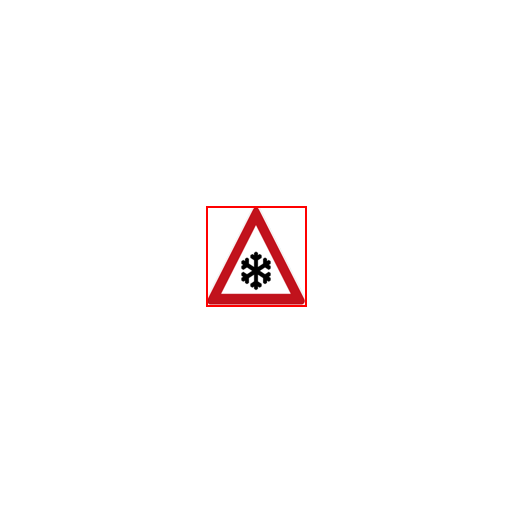

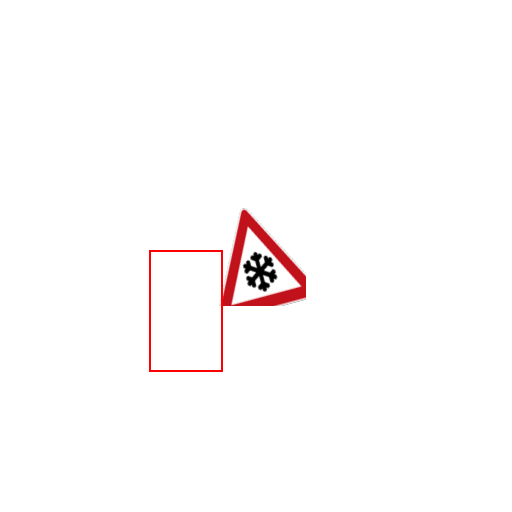

In [144]:
import numpy as np
from math import pi, cos, sin
from PIL import Image, ImageDraw, ImageFilter
from skimage import io, transform

# use pil to create a new image with a white background
background_img = Image.new("RGB", (512, 512), (255, 255, 255))
tmp_bg = background_img.copy()
smaller_img = Image.open("smaller.png")
smaller_img = smaller_img.resize((100, 100))
# get center of background image
center_bg = (background_img.width / 2, background_img.height / 2)
# paste smaller image on background image
tmp_bg.paste(smaller_img, (int(center_bg[0] - smaller_img.width / 2), int(center_bg[1] - smaller_img.height / 2)), smaller_img)

# define initial bounding box corners
# x0y0 = upper left corner
# x1y1 = lower right corner
x0y0 = (center_bg[0] - smaller_img.width // 2, center_bg[1] - smaller_img.height // 2)
x1y1 = (center_bg[0] + smaller_img.width // 2, center_bg[1] + smaller_img.height // 2)
x0y1 = (x0y0[0], x0y0[1] + smaller_img.height)
x1y0 = (x0y0[0] + smaller_img.width, x0y0[1])

# draw bounding box around smaller image
draw = ImageDraw.Draw(tmp_bg)
draw.rectangle((x0y0, x1y1), outline="red", width=2)
display(tmp_bg)

# define angles
theta = 15
phi = 0
gamma = 15
# calculate transformation matrix
transform_matrix = calculate_transformation_matrix(smaller_img.width, smaller_img.height, theta=theta, phi=phi, gamma=gamma, dx=0, dy=0, dz=0)

# get bounding box coordinates of traffic sign to 3d vector
upper_left = np.array([x0y0[0], x0y0[1], 0])
upper_right = np.array([x1y0[0], x1y0[1], 0])
lower_left = np.array([x0y1[0], x0y1[1], 0])
lower_right = np.array([x1y1[0], x1y1[1], 0])

# rotate bounding box coordinates
upper_left = rotate_vector(upper_left, theta=theta, phi=phi, gamma=gamma)
upper_right = rotate_vector(upper_right, theta=theta, phi=phi, gamma=gamma)
lower_left = rotate_vector(lower_left, theta=theta, phi=phi, gamma=gamma)
lower_right = rotate_vector(lower_right, theta=theta, phi=phi, gamma=gamma)

# calculate 2d projection of 3d bounding box coordinates
x_axis = np.array([1, 0, 0])
y_axis = np.array([0, 1, 0])
upper_left_proj = x_axis * np.dot(upper_left, x_axis) + y_axis * np.dot(upper_left, y_axis)
upper_left = upper_left_proj * (np.linalg.norm(upper_left) / np.linalg.norm(upper_left_proj))
upper_right_proj = x_axis * np.dot(upper_right, x_axis) + y_axis * np.dot(upper_right, y_axis)
upper_right = upper_right_proj * (np.linalg.norm(upper_right) / np.linalg.norm(upper_right_proj))
lower_left_proj = x_axis * np.dot(lower_left, x_axis) + y_axis * np.dot(lower_left, y_axis)
lower_left = lower_left_proj * (np.linalg.norm(lower_left) / np.linalg.norm(lower_left_proj))
lower_right_proj = x_axis * np.dot(lower_right, x_axis) + y_axis * np.dot(lower_right, y_axis)
lower_right = lower_right_proj * (np.linalg.norm(lower_right) / np.linalg.norm(lower_right_proj))

# transform smaller image
smaller_img = np.array(smaller_img)
transform_matrix = transform.AffineTransform(matrix=transform_matrix)
smaller_img_transformed = transform.warp(smaller_img, transform_matrix)

# convert transformed image to PIL image
smaller_img_transformed = Image.fromarray((smaller_img_transformed * 255).astype(np.uint8))
# paste transformed image on background image
background_img.paste(smaller_img_transformed, (int(center_bg[0] - smaller_img_transformed.width / 2), int(center_bg[1] - smaller_img_transformed.height / 2)), smaller_img_transformed)
# draw bounding box around traffic sign
draw = ImageDraw.Draw(background_img)
# untransformed bounding box
draw.rectangle((upper_left[0], upper_left[1], lower_right[0], lower_right[1]), outline="red", width=2)
display(background_img)

(206, 206) (306, 306) (206, 306) (306, 206)


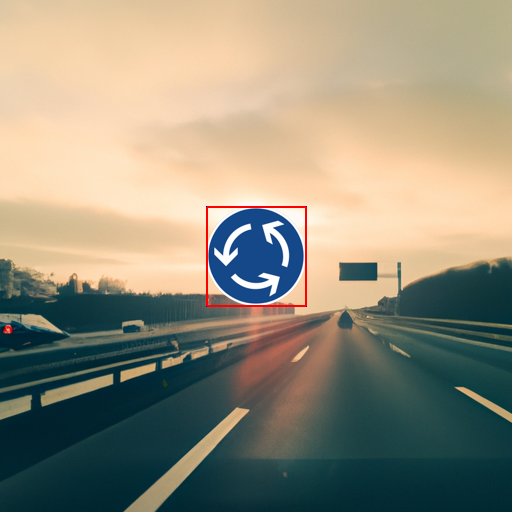

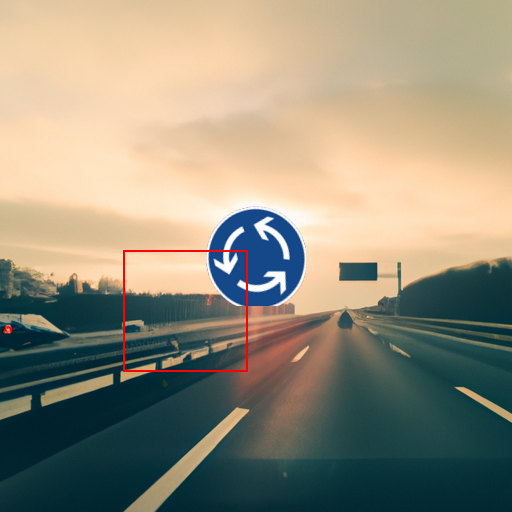

In [141]:
background = Image.open(f"{BACKGROUND_PATH}/background_{random.randint(0, len(os.listdir(BACKGROUND_PATH)) - 1)}.png")
tmp_bg = background.copy()
traffic_sign = Image.open(f"{TRAFFIC_SIGN_PATH}/{random.choice(os.listdir(TRAFFIC_SIGN_PATH))}")
traffic_sign = traffic_sign.resize((100, 100))
# get middle position of background
bg_pos = (tmp_bg.width // 2, tmp_bg.height // 2)
# paste traffic sign on background
tmp_bg.paste(traffic_sign, (bg_pos[0] - traffic_sign.width // 2, bg_pos[1] - traffic_sign.height // 2), traffic_sign)

# define initial bounding box corners
# x0y0 = upper left corner
# x1y1 = lower right corner
x0y0 = (bg_pos[0] - traffic_sign.width // 2, bg_pos[1] - traffic_sign.height // 2)
x1y1 = (bg_pos[0] + traffic_sign.width // 2, bg_pos[1] + traffic_sign.height // 2)
x0y1 = (x0y0[0], x0y0[1] + traffic_sign.height)
x1y0 = (x0y0[0] + traffic_sign.width, x0y0[1])

print (x0y0, x1y1, x0y1, x1y0)
# draw bounding box around traffic sign
draw = ImageDraw.Draw(tmp_bg)
draw.rectangle((x0y0, x1y1), outline="red", width=2)
draw.point(x0y0, fill="blue")
draw.point(x1y1, fill="blue")
draw.point(x0y1, fill="blue")
draw.point(x1y0, fill="blue")
# show image
display(tmp_bg)

# define angles
theta = 15
phi = 0
gamma = 15
# calculate transformation matrix
transform_matrix = calculate_transformation_matrix(traffic_sign.width, traffic_sign.height, theta=theta, phi=phi, gamma=gamma, dx=0, dy=0, dz=0)

# get bounding box coordinates of traffic sign to 3d vector
upper_left = np.array([x0y0[0], x0y0[1], 0])
upper_right = np.array([x1y0[0], x1y0[1], 0])
lower_left = np.array([x0y1[0], x0y1[1], 0])
lower_right = np.array([x1y1[0], x1y1[1], 0])

# print bounding box coordinates
# print(upper_left)
# print(upper_right)
# print(lower_left)
# print(lower_right)

# rotate bounding box coordinates
upper_left = rotate_vector(upper_left, theta=theta, phi=phi, gamma=gamma)
upper_right = rotate_vector(upper_right, theta=theta, phi=phi, gamma=gamma)
lower_left = rotate_vector(lower_left, theta=theta, phi=phi, gamma=gamma)
lower_right = rotate_vector(lower_right, theta=theta, phi=phi, gamma=gamma)

# print bounding box coordinates
# print(upper_left)
# print(upper_right)
# print(lower_left)
# print(lower_right)

# calculate 2d projection of 3d bounding box coordinates
x_axis = np.array([1, 0, 0])
y_axis = np.array([0, 1, 0])
upper_left_proj = x_axis * np.dot(upper_left, x_axis) + y_axis * np.dot(upper_left, y_axis)
upper_left = upper_left_proj * (np.linalg.norm(upper_left) / np.linalg.norm(upper_left_proj))
upper_right_proj = x_axis * np.dot(upper_right, x_axis) + y_axis * np.dot(upper_right, y_axis)
upper_right = upper_right_proj * (np.linalg.norm(upper_right) / np.linalg.norm(upper_right_proj))
lower_left_proj = x_axis * np.dot(lower_left, x_axis) + y_axis * np.dot(lower_left, y_axis)
lower_left = lower_left_proj * (np.linalg.norm(lower_left) / np.linalg.norm(lower_left_proj))
lower_right_proj = x_axis * np.dot(lower_right, x_axis) + y_axis * np.dot(lower_right, y_axis)
lower_right = lower_right_proj * (np.linalg.norm(lower_right) / np.linalg.norm(lower_right_proj))

# print bounding box coordinates
# print(upper_left)
# print(upper_right)
# print(lower_left)
# print(lower_right)

# convert traffic sign to numpy array
traffic_sign = np.array(traffic_sign)
transform_matrix = transform.AffineTransform(matrix=transform_matrix)
traffic_sign = transform.warp(traffic_sign, transform_matrix)


tmp_bg = background.copy()

# strip last dimension of 3d vectors
upper_left = upper_left[:2]
upper_right = upper_right[:2]
lower_left = lower_left[:2]
lower_right = lower_right[:2]
# convert to tuple
upper_left = tuple(upper_left.astype(np.int32))
upper_right = tuple(upper_right.astype(np.int32))
lower_left = tuple(lower_left.astype(np.int32))
lower_right = tuple(lower_right.astype(np.int32))
# print(upper_left)
# print(upper_right)
# print(lower_left)
# print(lower_right)

# add every corner to list 
corners = [upper_left, upper_right, lower_left, lower_right]
# loop over corners
x_min = corners[0][0]
y_min = corners[0][1]
x_max = corners[0][0]
y_max = corners[0][1]
for corner in corners:
    x_min = corner[0] if corner[0] < x_min else x_min
    y_min = corner[1] if corner[1] < y_min else y_min
    x_max = corner[0] if corner[0] > x_max else x_max
    y_max = corner[1] if corner[1] > y_max else y_max
    # update corners
    upper_left = (x_min, y_min)
    lower_right = (x_max, y_max)


# convert traffic sign to PIL image
traffic_sign = Image.fromarray((traffic_sign * 255).astype(np.uint8))
# paste traffic sign on background
tmp_bg.paste(traffic_sign, (bg_pos[0] - traffic_sign.width // 2, bg_pos[1] - traffic_sign.height // 2), traffic_sign)
# draw bounding box around traffic sign
draw = ImageDraw.Draw(tmp_bg)
# untransformed bounding box
draw.rectangle((upper_left[0], upper_left[1], lower_right[0], lower_right[1]), outline="red", width=2)
draw.point(upper_left, fill="green")
draw.point(upper_right, fill="green")
draw.point(lower_left, fill="green")
draw.point(lower_right, fill="green")

# show image
display(tmp_bg)

In [134]:
w = 100
h = 100
angle = 30
nw = w * np.cos(angle) + h * np.sin(angle)
nh = h * np.cos(angle) + w * np.sin(angle)
print(nw)
print(nh)

-83.37801742052778
-83.37801742052778
